In [21]:
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, concatenate
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import wget
import zipfile as zf

%matplotlib inline

In [2]:
TRAIN_DIR = './train'
TEST_DIR = './test'
TRAIN_ZFILE = 'train.zip'
TEST_ZFILE = 'test.zip'

In [31]:
def may_download_or_extract(url, zfile, zdir):
    
    if not os.path.isdir(zdir):
        if not zf.is_zipfile(zfile):
            wget.download(url, zfile)
            
        with zf.ZipFile(zfile) as my_zip:
                my_zip.extractall()            

In [37]:
train_url = ''
test_url = ''

with open('data_url.txt', 'r') as f:
    train_url = f.readline()
    test_url = f.readline()

may_download_or_extract(train_url, TRAIN_ZFILE, TRAIN_DIR)
may_download_or_extract(test_url, TEST_ZFILE, TEST_DIR)

In [2]:
def load_train_images(imgs_dir):
    
    img_names = np.array(os.listdir(imgs_dir))
    n_imgs = len(img_names)
    
    x = np.zeros((n_imgs, 299, 299, 3), dtype=np.float32)
    y = np.zeros((n_imgs,), dtype=np.bool)
    
    # shuffle the images    
    indices = np.arange(len(img_names))
    np.random.shuffle(indices)
    img_names = img_names[indices]
    
    for i, img_name in tqdm(enumerate(img_names)):
        img_path = os.path.join(imgs_dir, img_name)
        img = cv2.resize(cv2.imread(img_path), dsize=(299, 299))
        x[i] = img
        if img_name.startswith('cat'):
            y[i] = False
        else:
            y[i] = True
    
    return x, y

In [3]:
def load_test_images(imgs_dir):
    
    img_names = np.array(os.listdir(imgs_dir))
    n_imgs = len(img_names)
    
    ids = np.zeros((n_imgs,), dtype='<U6')
    x = np.zeros((n_imgs, 299, 299, 3), dtype=np.float32)
    
    for i, img_name in tqdm(enumerate(img_names)):
        img_path = os.path.join(imgs_dir, img_name)
        img = cv2.resize(cv2.imread(img_path), dsize=(299, 299))
        ids[i] = img_name[:-4]
        x[i] = img
    
    return ids, x

In [4]:
def preprocess_input(x):
    
    x /= 127.5
    x -= 1.
    
    return x

In [5]:
#示例图片
def show_img_examples(x, y):    
    
    inds = np.random.randint(len(y),size=12)
    x_examples = x[inds] / 255.
    y_examples = y[inds]
    fig = plt.figure(figsize=(20,8))
    
    for i, (img, cls) in enumerate(zip(x_examples, y_examples)):
        a = fig.add_subplot(2, 6, i+1)
        plt.imshow(img)
        a.set_title('dog {:.2f}%'.format(cls*100) if cls>0.5 else 'cat {:.2f}%'.format((1-cls)*100))
    
    plt.show()

In [6]:
def my_model(lr):
    
    input_tensor = Input(shape=(299, 299, 3))
        
    base_model_1 = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    base_model_2 = InceptionV3(input_tensor=input_tensor, include_top=False, weights='imagenet')
        
    x1 = base_model_1.output
    x2 = base_model_2.output
    
    x1 = GlobalAveragePooling2D()(x1)
    x2 = GlobalAveragePooling2D()(x2)
    
    x = concatenate([x1, x2], axis=-1)
        
    x = Dense(1024, activation='relu')(x)
        
    predictions = Dense(1, activation='sigmoid')(x)
    
    # this is the model we will train
    model = Model(inputs=input_tensor, outputs=predictions)
        
    # freeze all base model layers
    for layer in base_model_1.layers:
        layer.trainable = False
        
    for layer in base_model_2.layers:
        layer.trainable = False
        
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
x_train, y_train = load_train_images(TRAIN_DIR)

2000it [00:52, 38.12it/s]


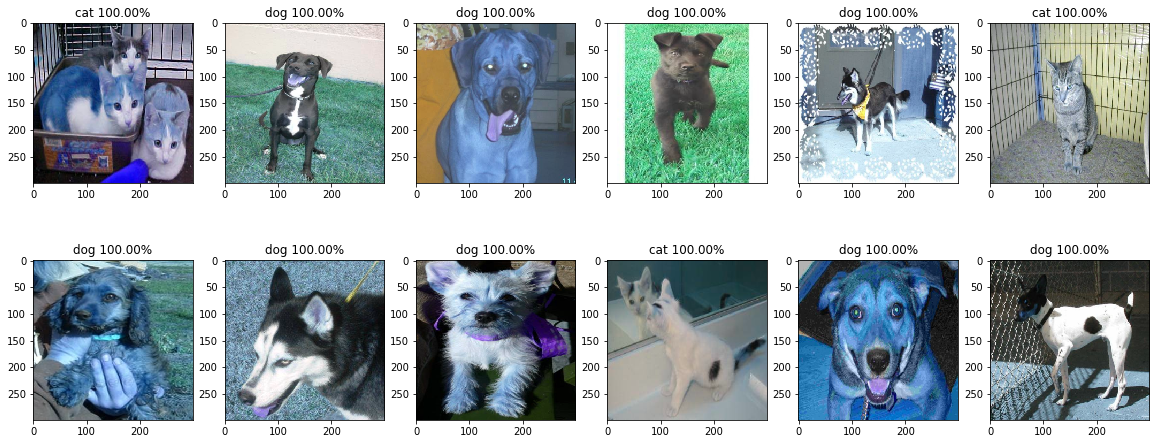

In [8]:
show_img_examples(x_train, y_train)

In [9]:
x_train = preprocess_input(x_train)

In [11]:
model = my_model(0.001)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 149, 149, 32) 96          conv2d_103[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_103[0][0]    
__________________________________________________________________________________________________
conv2d_104

In [12]:
# training
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=128)
model.save('my_model.h5')

Train on 160 samples, validate on 40 samples
Epoch 1/5
160/160 [==============================] - 328s 2s/step - loss: 0.8591 - acc: 0.7438 - val_loss: 0.3038 - val_acc: 0.8000
Epoch 2/5
160/160 [==============================] - 327s 2s/step - loss: 0.2450 - acc: 0.9187 - val_loss: 0.2014 - val_acc: 0.9500
Epoch 3/5
160/160 [==============================] - 338s 2s/step - loss: 0.3428 - acc: 0.9000 - val_loss: 0.1987 - val_acc: 0.9500
Epoch 4/5
160/160 [==============================] - 341s 2s/step - loss: 0.1918 - acc: 0.9375 - val_loss: 0.3121 - val_acc: 0.9250
Epoch 5/5
160/160 [==============================] - 342s 2s/step - loss: 0.0171 - acc: 1.0000 - val_loss: 0.2253 - val_acc: 0.9500


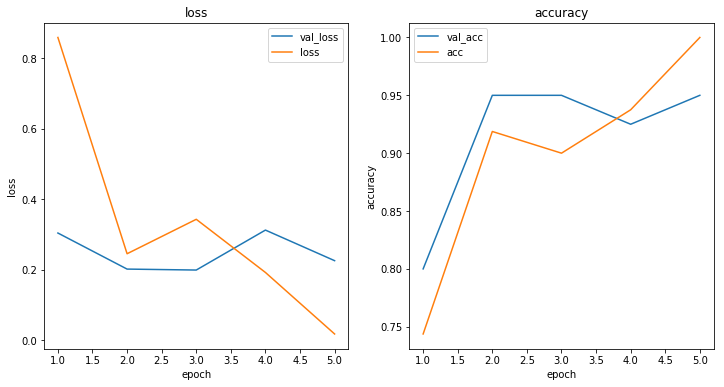

In [13]:
his = hist.history
epochs = list(range(1, 6))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('loss')
plt.plot(epochs, his['val_loss'], label='val_loss')
plt.plot(epochs, his['loss'], label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.title('accuracy')
plt.plot(epochs, his['val_acc'], label='val_acc')
plt.plot(epochs, his['acc'], label='acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [ ]:
ids, x_test = load_test_images(TEST_DIR)
x_test = preprocess_input(x_test)

preds = model.predict(x_test, batch_size=128)

600it [00:28, 21.37it/s]


In [ ]:
show_img_examples(x_test, preds[:,0])

In [ ]:
# save predictions as a csv file
import pandas as pd
dic = {'id':ids, 'label':preds[:,0]}
df = pd.DataFrame(dic)
df.to_csv('submission.csv', index=False)